In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


In [2]:
print("Hello World!")

Hello World!


In [3]:
df = pd.read_csv("data/realtor-data.csv", low_memory=False)
df.head().T

,0,1,2,3,4
brokered_by,103378.0,52707.0,103379.0,31239.0,34632.0
status,for_sale,for_sale,for_sale,for_sale,for_sale
price,105000.0,80000.0,67000.0,145000.0,65000.0
bed,3.0,4.0,2.0,4.0,6.0
bath,2.0,2.0,1.0,2.0,2.0
acre_lot,0.12,0.08,0.15,0.1,0.05
street,1962661.0,1902874.0,1404990.0,1947675.0,331151.0
city,Adjuntas,Adjuntas,Juana Diaz,Ponce,Mayaguez
state,Puerto Rico,Puerto Rico,Puerto Rico,Puerto Rico,Puerto Rico
zip_code,601.0,601.0,795.0,731.0,680.0


In [4]:
df.shape

(2226382, 12)

In [5]:
# df['state'].value_counts()

## Preprocess

In [6]:
df.shape

(2226382, 12)

In [7]:
from sklearn.preprocessing import LabelEncoder

## Labels turns categorical data into numerical values useful for many categories.
## If we used one hot encoding it would create too many columns
le = LabelEncoder()
df['state'] = le.fit_transform(df['state'])

# Fill missing values
df['price'] = df['price'].fillna(df['price'].median())
df['house_size'] = df['house_size'].fillna(df['house_size'].median())
df['acre_lot'] = df['acre_lot'].fillna(df['acre_lot'].median())
df['bed'] = df['bed'].fillna(df['bed'].mode()[0])
df['bath'] = df['bath'].fillna(df['bath'].mode()[0])
# df['city'] = df['city'].fillna('Unknown')






print(df.isnull().sum())  # Identify missing values


brokered_by         4533
status                 0
price                  0
bed                    0
bath                   0
acre_lot               0
street             10866
city                1407
state                  0
zip_code             299
house_size             0
prev_sold_date    734297
dtype: int64


In [8]:
df.head().T
city_counts = df['city'].value_counts(normalize=True)
city_counts

city
Houston                        1.072461e-02
Chicago                        8.196946e-03
New York City                  5.678266e-03
Jacksonville                   5.277812e-03
Philadelphia                   4.696233e-03
                                   ...     
Angel Ifre                     4.494433e-07
Colfax County Moreno Valley    4.494433e-07
Little Sioux                   4.494433e-07
Trementina                     4.494433e-07
Kahlotus                       4.494433e-07
Name: proportion, Length: 20098, dtype: float64

In [9]:
# # Convert data types
# df['city'] = df['city'].astype('category')  # Convert to category
# df['state'] = df['state'].astype('category')  # Categorical if used for prediction\
# df['bed'] = df['bed'].astype('int32')  # Convert to integer
# df['bath'] = df['bath'].astype('float32')  # Float for fractional values
# df['acre_lot'] = df['acre_lot'].astype('float32')  # Float for memory efficiency

# # Convert date column to datetime
# df['prev_sold_date'] = pd.to_datetime(df['prev_sold_date'], errors='coerce')  # Handle invalid dates

# # Drop unnecessary columns
# df.drop(['brokered_by', 'status', 'street'], axis=1, inplace=True)


In [10]:
# Compute mean price for each city
city_price_avg = df.groupby('city')['price'].mean()

# Map the mean price to the city column
df['city_encoded'] = df['city'].map(city_price_avg)

# state average price
state_price_avg = df.groupby('state')['price'].mean()

# Replace missing or rare cities with the state mean
df['city_encoded'] = df['city_encoded'].fillna(df['state'].map(state_price_avg))



In [11]:
# Drop the original city column
df.drop(['city'], axis=1, inplace=True)

In [12]:
df.head().T

,0,1,2,3,4
brokered_by,103378.0,52707.0,103379.0,31239.0,34632.0
status,for_sale,for_sale,for_sale,for_sale,for_sale
price,105000.0,80000.0,67000.0,145000.0,65000.0
bed,3.0,4.0,2.0,4.0,6.0
bath,2.0,2.0,1.0,2.0,2.0
acre_lot,0.12,0.08,0.15,0.1,0.05
street,1962661.0,1902874.0,1404990.0,1947675.0,331151.0
state,41,41,41,41,41
zip_code,601.0,601.0,795.0,731.0,680.0
house_size,920.0,1527.0,748.0,1800.0,1760.0


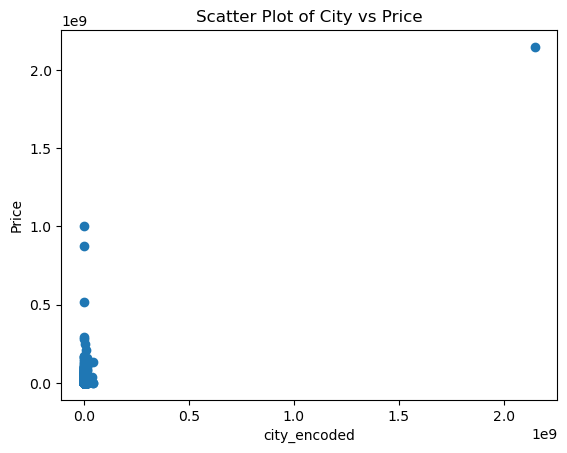

In [13]:
# Searching for outliers in price
plt.scatter(df['city_encoded'], df['price'])
plt.title('Scatter Plot of City vs Price')
plt.xlabel('city_encoded')
plt.ylabel('Price')
plt.show()



In [14]:
# Remove outliers in price
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]


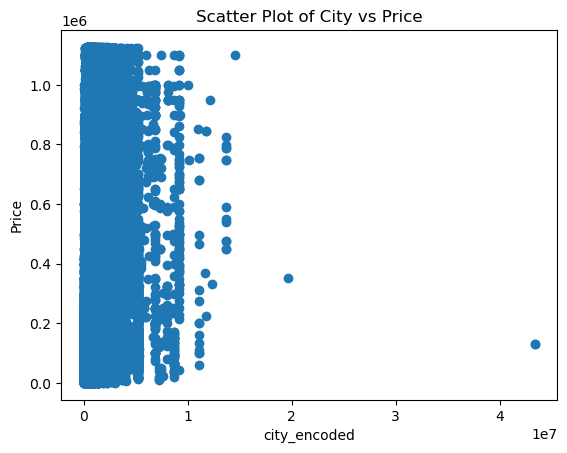

In [15]:
plt.scatter(df['city_encoded'], df['price'])
plt.title('Scatter Plot of City vs Price')
plt.xlabel('city_encoded')
plt.ylabel('Price')
plt.show()


In [16]:
# Remove outliers in city
# Calculate IQR
Q1 = df['city_encoded'].quantile(0.25)
Q3 = df['city_encoded'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip outliers
df['city_encoded'] = df['city_encoded'].clip(lower=lower_bound, upper=upper_bound)

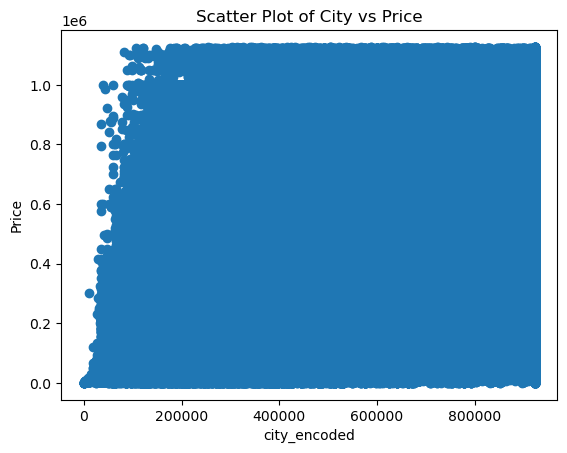

In [17]:
plt.scatter(df['city_encoded'], df['price'])
plt.title('Scatter Plot of City vs Price')
plt.xlabel('city_encoded')
plt.ylabel('Price')
plt.show()

In [18]:
df.shape

(2054782, 12)

In [19]:
df.head().T


,0,1,2,3,4
brokered_by,103378.0,52707.0,103379.0,31239.0,34632.0
status,for_sale,for_sale,for_sale,for_sale,for_sale
price,105000.0,80000.0,67000.0,145000.0,65000.0
bed,3.0,4.0,2.0,4.0,6.0
bath,2.0,2.0,1.0,2.0,2.0
acre_lot,0.12,0.08,0.15,0.1,0.05
street,1962661.0,1902874.0,1404990.0,1947675.0,331151.0
state,41,41,41,41,41
zip_code,601.0,601.0,795.0,731.0,680.0
house_size,920.0,1527.0,748.0,1800.0,1760.0


In [20]:
df["status"].value_counts()

status
for_sale          1271105
sold               759179
ready_to_build      24498
Name: count, dtype: int64

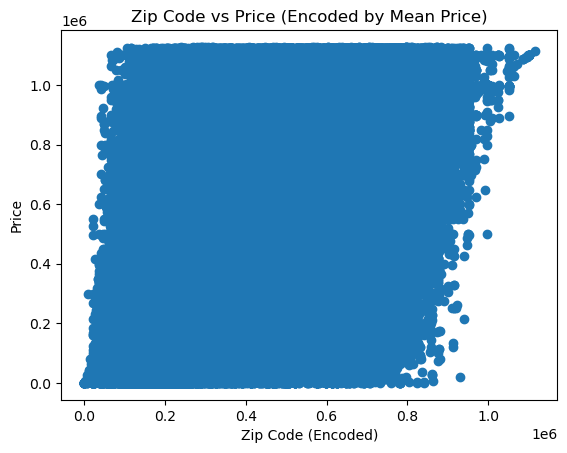

In [21]:
# Calculate the mean price for each zip code
zip_code_avg_price = df.groupby('zip_code')['price'].mean()

# Map the mean price to the zip_code_encoded column
df['zip_code_encoded'] = df['zip_code'].map(zip_code_avg_price)
# df = pd.get_dummies(df, columns=['zip_code'], prefix='zip')
# df.head().T
# Scatter plot of zip codes vs. price (after target encoding)
plt.scatter(df['zip_code_encoded'], df['price'])
plt.title('Zip Code vs Price (Encoded by Mean Price)')
plt.xlabel('Zip Code (Encoded)')
plt.ylabel('Price')
plt.show()

In [22]:
# Deciding whether to keep city or zip by correaltion matrix
# remember city and zip is now the mean price of all prices within the city / mzip
correlation_matrix = df[['zip_code_encoded', 'city_encoded', 'price']].corr()
print(correlation_matrix)
# Conclusion average price within a zip has more correlation to price than city. Multiple cities can share a zip.

                  zip_code_encoded  city_encoded     price
zip_code_encoded          1.000000      0.759956  0.687905
city_encoded              0.759956      1.000000  0.532368
price                     0.687905      0.532368  1.000000


In [23]:
# Using feature important to test if zip or city has more importance
# Randomly sample 10% of the data.
sampled_df = df.sample(frac=0.1, random_state=42)

# Test feature importance on the smaller dataset
from sklearn.ensemble import RandomForestRegressor

X = sampled_df[['zip_code_encoded', 'city_encoded']]
y = sampled_df['price']

model = RandomForestRegressor()
model.fit(X, y)

# Get feature importance
importance = model.feature_importances_
print(f"City Encoded Importance: {importance[1]}, Zip Code Importance: {importance[0]}")



City Encoded Importance: 0.08385041528628986, Zip Code Importance: 0.9161495847137101


In [24]:
# Drop unimportant columns
df.drop(['brokered_by', 'street', 'status', 'prev_sold_date', 'city_encoded', 'zip_code'], axis=1, inplace=True)
# df.drop(['brokered_by', 'street', 'status', 'prev_sold_date'], axis=1, inplace=True)


In [25]:
df.head().T

,0,1,2,3,4
price,105000.00,80000.00,67000.00,145000.000000,65000.000000
bed,3.00,4.00,2.00,4.000000,6.000000
bath,2.00,2.00,1.00,2.000000,2.000000
acre_lot,0.12,0.08,0.15,0.100000,0.050000
state,41.00,41.00,41.00,41.000000,41.000000
house_size,920.00,1527.00,748.00,1800.000000,1760.000000
zip_code_encoded,92500.00,92500.00,108112.50,155228.571429,147542.659574


In [26]:
print(df.dtypes)


price               float64
bed                 float64
bath                float64
acre_lot            float64
state                 int32
house_size          float64
zip_code_encoded    float64
dtype: object


In [27]:
print(df.isnull().sum())


price                 0
bed                   0
bath                  0
acre_lot              0
state                 0
house_size            0
zip_code_encoded    256
dtype: int64


In [28]:
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype('float32')

for col in df.select_dtypes(include=['int64']).columns:
    df[col] = df[col].astype('int32')


In [42]:


print("After Conversion:")
print(df.info(memory_usage='deep'))


After Conversion:
<class 'pandas.core.frame.DataFrame'>
Index: 2054782 entries, 0 to 2226381
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   price             float32
 1   bed               float32
 2   bath              float32
 3   acre_lot          float32
 4   state             int32  
 5   house_size        float32
 6   zip_code_encoded  float32
dtypes: float32(6), int32(1)
memory usage: 70.5 MB
None


In [30]:
# from sklearn.preprocessing import StandardScaler

numerical_features = ['bed', 'bath', 'acre_lot', 'house_size', 'zip_code_encoded']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])


In [31]:
print(df.isnull().sum())  # Identify missing values


price                 0
bed                   0
bath                  0
acre_lot              0
state                 0
house_size            0
zip_code_encoded    256
dtype: int64


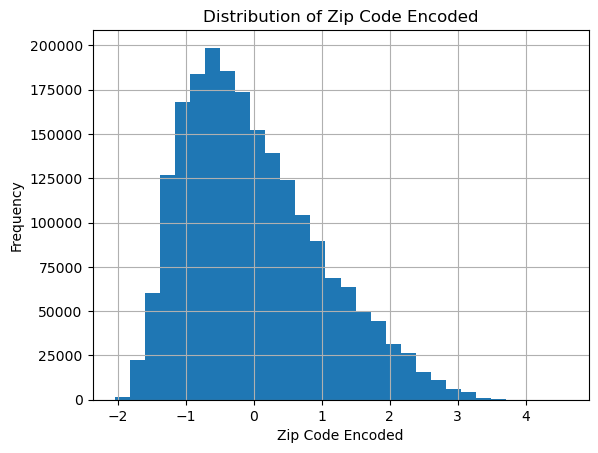

In [32]:
import matplotlib.pyplot as plt

df['zip_code_encoded'].hist(bins=30)
plt.title('Distribution of Zip Code Encoded')
plt.xlabel('Zip Code Encoded')
plt.ylabel('Frequency')
plt.show()


In [33]:
df['zip_code_encoded'] = df.groupby('state')['zip_code_encoded'].transform(
    lambda x: x.fillna(x.mean())
)


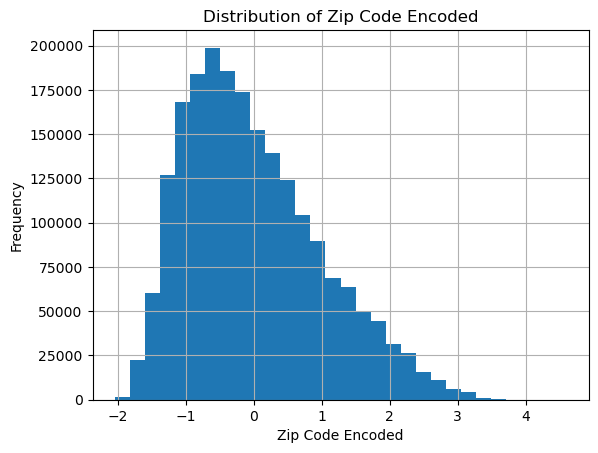

In [34]:
import matplotlib.pyplot as plt

df['zip_code_encoded'].hist(bins=30)
plt.title('Distribution of Zip Code Encoded')
plt.xlabel('Zip Code Encoded')
plt.ylabel('Frequency')
plt.show()

In [35]:

# Define the target variable
y = df['price']  # Target variable
# Drop the target column and any unwanted columns from the DataFrame
X = df.drop(columns=['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# model = LinearRegression()
# model.fit(X_train, y_train)\
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [37]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
print("R^2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

R^2 Score: 0.7919696791992775
RMSE: 111436.1773473831
MAE: 69891.23066831853


In [38]:
# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly.fit_transform(X)

In [39]:
importances = model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")


bed: 0.018334906820221576
bath: 0.030393469199539943
acre_lot: 0.1085702837963079
state: 0.05411643717919263
house_size: 0.24587938684664057
zip_code_encoded: 0.5427055161580975


In [40]:
# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# random_search = RandomizedSearchCV(
#     estimator=model, 
#     param_distributions=param_dist, 
#     n_iter=5,  # Number of random combinations to test
#     cv=3,       # Cross-validation folds
#     random_state=42,
#     verbose=1,
#     n_jobs=-1   # Parallelize
# )
# random_search.fit(X_train, y_train)
# print("Best Parameters:", random_search.best_params_)


In [41]:
import joblib

# Save the model to a file
joblib.dump(model, 'house_price_model_v1.pkl')


['house_price_model_v1.pkl']